In [1]:
import os
import numpy as np

import random
random.seed(123)

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import torch
torch.manual_seed(123);

import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import transforms

import pytorch_lightning as pl

import cv2
from PIL import Image

%load_ext autoreload
%autoreload 1
%aimport utils_loss
%aimport metrics

from utils_loss import CustomLoss

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataloader

In [3]:
class UCF_VIDEOS_DATASET(torch.utils.data.Dataset):
    
    def __init__(self, path_to_annotation, path_to_videos, seq_len):
        super(UCF_VIDEOS_DATASET, self).__init__()
        self.path_to_annotation = path_to_annotation
        self.path_to_videos = path_to_videos
        self.annotation_array = [] # [video_path, anomaly_frame] if anomaly_frame == -1 normal_video
        with open(path_to_annotation, 'r') as fp:
            for line in fp:
                splited_line = line.split("  ")
                if(splited_line[1] == "Explosion"):
                    self.annotation_array.append([splited_line[0], int(splited_line[2])])
                if(splited_line[1] == "Normal"):
                    self.annotation_array.append([splited_line[0], -1])        
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.annotation_array) - 1
        
    def __getitem__(self, item_idx):
        sequence_imgs = []
        sequence_labels = []
        step_size = 4
        frame_block_iter = 0
        frame_block_iter_length = 0
        frame_counter = 0
        video_name = self.annotation_array[item_idx][0]
        video_anomaly_frame = self.annotation_array[item_idx][1]
        cap = cv2.VideoCapture(os.path.join(self.path_to_videos, video_name))
        total_video_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        preprocess = transforms.Compose([
                                 transforms.Resize((224, 224)),
                                 #transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ])
        
        if video_anomaly_frame == -1:
            video_normal_frame = random.randint(int(total_video_frames / 4) , int(total_video_frames *3/4))
#             left_frames_length = video_normal_frame - 0
#             right_frames_length = total_video_frames - video_normal_frame
            start_frame = video_normal_frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            while True:
                ret, frame = cap.read()
                if(frame_block_iter % step_size == 0):
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)
                    
                    sequence_labels.append(0)
        
                    sequence_imgs.append(preprocess(frame_pil)) 
                    
                    frame_block_iter = 0
                    frame_block_iter_length += 1
                frame_block_iter += 1
                if(frame_block_iter_length == self.seq_len): break
            
        if video_anomaly_frame != -1:
            left_frames_length = video_anomaly_frame - 0
            right_frames_length = total_video_frames - video_anomaly_frame
            # Если края меньше 4 секунд(В Explosion минимальная длина 9 секунд).
            # Так что максимальная длина 16 seq_len
            start_frame_delta = random.randint(0, ((self.seq_len - 1)  * step_size) - 1 ) + 1
            start_frame = video_anomaly_frame - start_frame_delta
            if left_frames_length < 4 * 30:
                start_frame_delta = random.randint(0, 19) + 1
                start_frame = video_anomaly_frame - start_frame_delta
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            if left_frames_length < 4 * 30:
                start_frame_delta = random.randint((self.seq_len * step_size) - 20, (self.seq_len * step_size))
                start_frame = video_anomaly_frame - start_frame_delta
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            frame_counter = start_frame
            while True:
                ret, frame = cap.read()
                if(frame_block_iter % step_size == 0):
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)
                    
                    if(frame_counter < video_anomaly_frame):
                         sequence_labels.append(0)
                    else:
                        sequence_labels.append(1)
                        
                    sequence_imgs.append(preprocess(frame_pil)) 
                    
                    frame_block_iter = 0
                    frame_block_iter_length += 1
                frame_block_iter += 1
                frame_counter += 1
                #print(frame_block_iter_length)
                if(frame_block_iter_length == self.seq_len): break

        sequence_labels = np.asarray(sequence_labels)
        sequence_labels = torch.from_numpy(sequence_labels)

        sequence_imgs = torch.stack(sequence_imgs)
        
        return sequence_imgs, sequence_labels

# Models

In [12]:
HIDDEN_CNN = 32
HIDDEN_LSTM = HIDDEN_CNN * 2

class FullyConnected(torch.nn.Module):
    def __init__(self, input_size=1280):
        super(FullyConnected, self).__init__()
        self.clas_block1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(input_size, HIDDEN_CNN)
        )
        
    def forward(self, x):
        x = self.clas_block1(x)
        return x.view(-1, HIDDEN_CNN)


class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        
        #self.cnn = mobile_net_v2
        self.cnn = nn.Sequential(*list(mobile_net_v2.features.children())[:6])
        #self.classifier = FullyConnected(input_size=HIDDEN_CNN)
        self.rnn = nn.LSTM(
            input_size=HIDDEN_CNN,  # 1280 if conv block mobile net used
            hidden_size=HIDDEN_LSTM, 
            num_layers=1,
            batch_first=True, 
            dropout=0.1)
        #self.rnn = nn.GRU(
        #    input_size=HIDDEN_CNN,  # 1280 if conv block mobile net used
        #    hidden_size=HIDDEN_LSTM, 
        #    num_layers=1,
        #    batch_first=True, 
        #    dropout=0.5)            
        
        self.linear = nn.Linear(HIDDEN_LSTM, 1)      
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        c_out = nn.functional.adaptive_avg_pool2d(c_out, (1, 1))
        c_out = torch.flatten(c_out, 1)
        #c_out = self.classifier(c_out)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, _ = self.rnn(r_in)
        r_out = r_out.reshape(batch_size * timesteps, -1)
        r_out = self.linear(r_out).view(batch_size, timesteps, -1)
        out = self.activation(r_out)
        return out    
    
mobile_net_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)    
mobile_net_v2.classifier = FullyConnected()

Using cache found in /home/eromanenkova/.cache/torch/hub/pytorch_vision_v0.6.0


In [10]:
# Test dataset
path_to_videos = "Explosion/"
path_annotation_test = "UCF_test.txt"   
imgs_dataset_test = UCF_VIDEOS_DATASET(path_annotation_test, path_to_videos, seq_len=16)        
test_dataloader = DataLoader(imgs_dataset_test, batch_size=16)

# Pytorch Lightning

In [9]:
class CPD_model(pl.LightningModule):
    def __init__(
        self,
        model, 
        batch_size: int = 16,
        seq_len: int = 16, 
        loss_type: str = 'bce',
        path_to_videos: str = "Explosion/",
        path_annotation_train: str = "UCF_train.txt",
        path_annotation_validation: str = "UCF_validation.txt",
        
    ):
        super(CPD_model, self).__init__()

        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        if loss_type == 'bce':
            self.loss = nn.BCELoss()
        else:
            self.loss = CustomLoss()
            
        self.imgs_dataset_train = UCF_VIDEOS_DATASET(path_annotation_train, path_to_videos, 
                                                     seq_len=self.seq_len)
        self.imgs_dataset_validation = UCF_VIDEOS_DATASET(path_annotation_validation, 
                                                          path_to_videos, seq_len=self.seq_len)        
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())

        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', train_accuracy, prog_bar=True, on_epoch=True)    
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())
        
        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.01) 
        return [opt]

    def train_dataloader(self):
        
        train_dataloader = DataLoader(self.imgs_dataset_train, batch_size=self.batch_size)
        return train_dataloader
        
    
    def val_dataloader(self):
        
        val_dataloader = DataLoader(self.imgs_dataset_validation, batch_size=self.batch_size)
        return val_dataloader

## Model BCE loss

In [12]:

model_bce = Combine()

# CNT = 157 if use all 

for param in model_bce.cnn.parameters():
    param.requires_grad = False

#cnt = 0
#for param in model_bce.parameters():
#    cnt+=1
#    if(cnt==157): break   # 18 to freeze all mobile net block
#    param.requires_grad = False
    
    
model_bce_pl = CPD_model(model=model_bce, batch_size=16, seq_len=16, loss_type='bce')    

experiment_name = 'bce_loss'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='min'
)

trainer_bce = pl.Trainer(
    max_epochs=40, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback])    

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [112]:
%load_ext tensorboard 
%tensorboard --logdir logs --port 2021

Reusing TensorBoard on port 2021 (pid 9966), started 1 day, 14:55:21 ago. (Use '!kill 9966' to kill it.)

In [113]:
trainer_bce.fit(model_bce_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 65.8 K
1 | loss  | BCELoss | 0     
----------------------------------
25.2 K    Trainable params
40.6 K    Non-trainable params
65.8 K    Total params
0.263     Total estimated model params size (MB)


In [15]:
# Test dataset
path_to_videos = "Explosion/"
path_annotation_test = "UCF_test.txt"   
imgs_dataset_test = UCF_VIDEOS_DATASET(path_annotation_test, path_to_videos, seq_len=16)        
test_dataloader = DataLoader(imgs_dataset_test, batch_size=16)

## Model CUSTOM loss

In [13]:
model_custom = Combine()
for param in model_custom.cnn.parameters():
    param.requires_grad = False
    
model_custom_pl = CPD_model(model=model_custom, batch_size=32, seq_len=16, loss_type='custom')    

experiment_name = 'custom_loss'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=10,
   verbose=False,
   mode='min'
)

trainer_custom = pl.Trainer(
    max_epochs=60, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback])    

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [14]:
trainer_custom.fit(model_custom_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Combine    | 65.8 K
1 | loss  | CustomLoss | 0     
-------------------------------------
25.2 K    Trainable params
40.6 K    Non-trainable params
65.8 K    Total params
0.263     Total estimated model params size (MB)


## Model COMBINED loss

In [25]:
model_combined = Combine()
for param in model_combined.cnn.parameters():
    param.requires_grad = False    

experiment_name = 'combined'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')

model_combined_pl_1 = CPD_model(model=model_combined, batch_size=16, seq_len=16, loss_type='bce')    

trainer_combined_1 = pl.Trainer(
    max_epochs=20, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback])    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [26]:
trainer_combined_1.fit(model_combined_pl_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 93.3 K
1 | loss  | BCELoss | 0     
----------------------------------
16.7 K    Trainable params
76.5 K    Non-trainable params
93.3 K    Total params
0.373     Total estimated model params size (MB)


In [27]:
model_combined_pl_2 = CPD_model(model=model_combined_pl_1.model.to(device), batch_size=16, seq_len=16, loss_type='custom')    

trainer_combined_2 = pl.Trainer(
    max_epochs=20, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger)
    #callbacks=[checkpoint_callback])    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [28]:
trainer_combined_2.fit(model_combined_pl_2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Combine    | 93.3 K
1 | loss  | CustomLoss | 0     
-------------------------------------
16.7 K    Trainable params
76.5 K    Non-trainable params
93.3 K    Total params
0.373     Total estimated model params size (MB)


## Get Pareto Metric

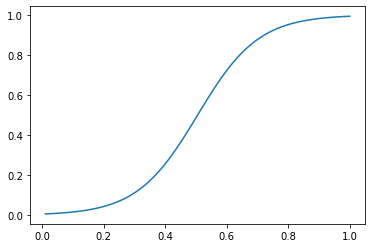

In [29]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [30]:
model_bce_pl.model.to(device)
_, _, delay_list_bce, fp_delay_list_bce = metrics.get_pareto_metrics_for_threshold(model_bce_pl.model, model_bce_pl.val_dataloader(), 16, threshold_list, seq_len=16)
print("BCE")

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 F

In [31]:
model_custom_pl.model.to(device)

_, _, delay_list_custom, fp_delay_list_custom = metrics.get_pareto_metrics_for_threshold(model_custom_pl.model, model_custom_pl.val_dataloader(), 16, threshold_list, seq_len=16)
print("CUSTOM")

TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 F

In [32]:
model_combined_pl_2.model.to(device)
_, _, delay_list_combined, fp_delay_list_combined = metrics.get_pareto_metrics_for_threshold(model_combined_pl_2.model, model_combined_pl_2.val_dataloader(), 16, threshold_list, seq_len=16)
print("COMBINED")

TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 FN: 0 DELAY: 0.0 FP_DELAY 0.0
TP: 0 TN: 0 FP: 80 F

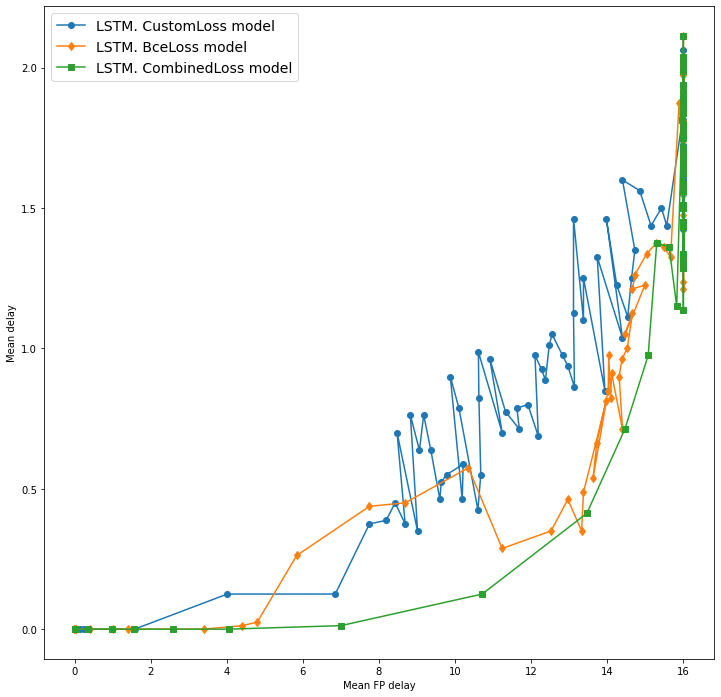

In [33]:
# with_lin_space
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_custom, delay_list_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(fp_delay_list_bce, delay_list_bce, '-d', label='LSTM. BceLoss model')
plt.plot(fp_delay_list_combined, delay_list_combined, '-s', label='LSTM. CombinedLoss model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

In [34]:
batch, labels = next(iter(model_bce_pl.train_dataloader()))

In [35]:
batch = batch.to(device)

In [36]:
labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [37]:
model_custom_pl.model.to(device)
model_bce_pl.model.to(device)
model_combined_pl_2.model.to(device)

Combine(
  (cnn): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, 

In [38]:
predictions = model_custom_pl.model(batch)
predictions_bce = model_bce_pl.model(batch)
predictions_comb = model_combined_pl_2.model(batch)

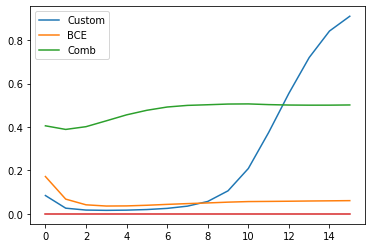

In [56]:
i = 11
plt.plot(predictions[i].detach().cpu(), label='Custom')
plt.plot(predictions_bce[i].detach().cpu(), label='BCE')
plt.plot(predictions_comb[i].detach().cpu(), label='Comb')
plt.plot(labels[i])
plt.legend()

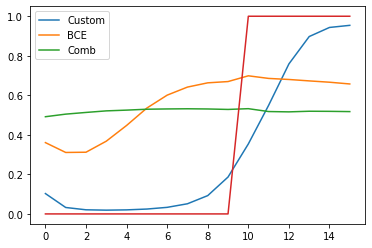

In [62]:
i = 7
plt.plot(predictions[i].detach().cpu(), label='Custom')
plt.plot(predictions_bce[i].detach().cpu(), label='BCE')
plt.plot(predictions_comb[i].detach().cpu(), label='Comb')
plt.plot(labels[i])
plt.legend()

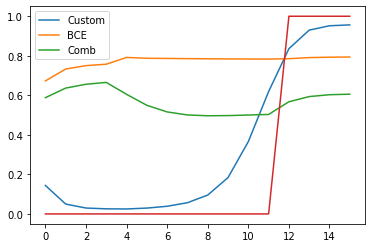

In [55]:
i = 
plt.plot(predictions[i].detach().cpu(), label='Custom')
plt.plot(predictions_bce[i].detach().cpu(), label='BCE')
plt.plot(predictions_comb[i].detach().cpu(), label='Comb')
plt.plot(labels[i])
plt.legend()

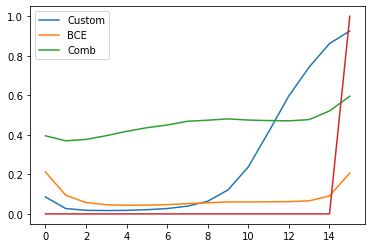

In [42]:
i = 3
plt.plot(predictions[i].detach().cpu(), label='Custom')
plt.plot(predictions_bce[i].detach().cpu(), label='BCE')
plt.plot(predictions_comb[i].detach().cpu(), label='Comb')
plt.plot(labels[i])
plt.legend()

In [ ]:
i = 14
plt.plot(predictions[i].detach().cpu(), label='Custom')
plt.plot(predictions_bce[i].detach().cpu(), label='BCE')
plt.plot(predictions_comb[i].detach().cpu(), label='Comb')
plt.plot(labels[i])
plt.legend()